Keras RNN API 有两大优点：
* 方便使用：内置的 tf.keras.layers.RNN, tf.keras.layers.LSTM, tf.keras.layers.GRU 可以快速实现循环神经网络模型；
* 方便定制化：可以定义自己的 RNN cell layer (the inner part of the **for** loop)

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

**Build a simple model**

Keras 中有三种内置的 RNN 层：
1. tf.keras.layers.SimpleRNN
2. tf.keras.layers.GRU
3. tf.keras.layers.LSTM

一个简单的例子：

In [2]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))  # ((128 + 64) * 128 + 128) * 4 = 98816

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


**Outputs and states**

默认情况下，RNN 层对每个样本只输出一个向量，即最后一个时刻的输出，shape=(batch_size, units)。如果设置了 return_sequence=True，RNN 层也可以返回所有时刻的输出，shape=(batch_size, timesteps, units)。

In [3]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


此外，RNN 层可以返回它最后的中间状态，该状态可以用于继续后面的 RNN 执行，或初始化另一个 RNN，如 encoder-decoder seq2seq 模型，其中 encoder 的最终状态可用作 decoder 的初始状态。

为了让 RNN 层返回中间状态，设置 return_state=True。记住，LSTM 有两个中间状态 tensor(state_h 和 state_c)，而 GRU 只有一个。

使用 initial_state 配置初始状态，shape 一定要匹配。如下例：

In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(encoder_input)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(
 64, return_state=True, name='encoder')(encoder_embedded)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(
    64, name='decoder')(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10)(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)  # 两个输入
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

**RNN layers and RNN cells**

除了内置的 RNN 层之外，RNN API 也提供了 cell-level 的 API，与 RNN 层处理输入序列的整个 batches 不同，RNN cell 只处理单个 timestep。cell 是 RNN 层的 for loop 的内部，在 tf.keras.layers.RNN 层里面封装 cell 也能得到和 RNN 层一样的效果，例如 RNN(LSTMCell(10))。

RNN(LSTMCell(10)) 看起来和 LSTM(10) 的效果一样，但是使用内置的 GRU 和 LSTM 层可以使用 CuDNN 获取更好的性能。

有三种内置的 cell，对应相应的 RNN 层：
* tf.keras.layers.SimpleRNNCell: 对应 SimpleRNN 层
* tf.keras.layers.GRUCell: 对应 GRU 层
* tf.keras.layers.LSTMCell: 对应 LSTM 层

**Cross-batch statefulness**

当处理非常长的序列时，会用到 cross-batch statefulness。通常，RNN 层遇到新的 batch 时会重置中间状态，在处理给定 sample 时，RNN 才会保存中间状态。但当处理非常长的序列时，通常要把它们分成较短的序列，这种情况下就不能重置状态了。这时，可以设置 stateful=True 来完成。如果有个序列 s = [t0, t1, ..., t1546, t1547]，将其分割为：
```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```
就可以这样处理

In [ ]:
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
    output = lstm_layer(s)

如果想清空 state，可以调用 layer.reset_states()，下面是一个完整的例子：

In [7]:
p1 = np.random.random((20, 10, 50)).astype(np.float32)
p2 = np.random.random((20, 10, 50)).astype(np.float32)
p3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(p1)
output = lstm_layer(p2)
output = lstm_layer(p3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()

**RNN State Reuse**

RNN 层的 states 不是在 layer.weights() 里。如果想复用 states，可以使用 layer.states，用它作为新层的初始状态。

In [8]:
p1 = np.random.random((20, 10, 50)).astype(np.float32)
p2 = np.random.random((20, 10, 50)).astype(np.float32)
p3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(p1)
output = lstm_layer(p2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(p3, initial_state=existing_state)

**Bidirectional RNNs**

对于除时间序列之外的序列（如文本），通常双向处理要比单向效果更好。这时就可以使用双向 RNN：tf.keras.layers.Bidirectional:

In [18]:
model = tf.keras.Sequential()

model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True),
                               input_shape=(5, 10)))  # ((64 + 10) * 64 + 64) * 4 * 2 = 38400
model.add(layers.Bidirectional(layers.LSTM(32)))  # ((128 + 32) * 32 + 32) * 4 * 2 = 41216
model.add(layers.Dense(10))  # 64 * 10 + 10 = 650

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


默认情况下，Bidirectional RNN 的输出为前向层和后向层的和，可以通过改变 merge_mode 的参数来改变合并方式，比如 concatenation。

**Performance optimization and CuDNN kernels in TensorFlow 2.0**

在 TF2.0 中，内置的 LSTM 和 GRU 层已被升级为当 GPU 可用时默认使用 CuDNN 内核，之前的 keras.kayers.CuDNNLSTM/CuDNNGRU 被废弃。

由于 CuDNN 内核基于一定的假设，当改变内置 LSTM, GRU 层的默认配置时，层将无法使用 CuDNN 内核：
* 改变 tanh 激活函数
* 改变 sigmoid recurrent_activation 函数
* 使用 recurrent_dropout > 0
* 将 unroll 设为 True
* 将 use_bias 设为 False
* 当输入数据不是严格右填充是使用 masking

**Using CuDNN kernels when available**

通过一个例子来展示性能差异：

In [19]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means 'LSTM(units)' will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units),
            input_shape=(None, input_dim))
    model = tf.keras.models.Sequential([
        lstm_layer,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_size)]
    )
    return model

In [21]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test/255.0
sample, sample_label = x_train[0], y_train[0]
sample.shape, sample_label

((28, 28), 5)

In [22]:
model = build_model(allow_cudnn_kernel=True)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='sgd',
              metrics=['accuracy'])

In [23]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 16s 274us/sample - loss: 0.9475 - accuracy: 0.7013 - val_loss: 0.5278 - val_accuracy: 0.8346
Epoch 2/5
60000/60000 [==============================] - 14s 238us/sample - loss: 0.4115 - accuracy: 0.8749 - val_loss: 0.4441 - val_accuracy: 0.8495
Epoch 3/5
60000/60000 [==============================] - 14s 241us/sample - loss: 0.2595 - accuracy: 0.9225 - val_loss: 0.3231 - val_accuracy: 0.9005
Epoch 4/5
60000/60000 [==============================] - 14s 240us/sample - loss: 0.1982 - accuracy: 0.9406 - val_loss: 0.3224 - val_accuracy: 0.8968
Epoch 5/5
60000/60000 [==============================] - 14s 239us/sample - loss: 0.1659 - accuracy: 0.9497 - val_loss: 0.3760 - val_accuracy: 0.8698


**Build a new model without CuDNN kernel**

In [24]:
slow_model = build_model(allow_cudnn_kernel=False)
slow_model.set_weights(model.get_weights())
slow_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   optimizer='sgd', 
                   metrics=['accuracy'])
slow_model.fit(x_train, y_train, 
               validation_data=(x_test, y_test), 
               batch_size=batch_size,
               epochs=1)  # We only train for one epoch because it's slower.

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 16s 274us/sample - loss: 0.1467 - accuracy: 0.9550 - val_loss: 0.2351 - val_accuracy: 0.9232


有 GPU 的情况下，CnDNN 的模型要比常规模型训练速度快。

同样的 CuDNN-enabled 模型也可以跑在只有 CPU 的环境下，当 GPU 不可用时，模型默认跑在 CPU 上。下面的代码展示了 CuDNN 模型跑在 CPU 上：

Predicted result is: [3], target result is: 5


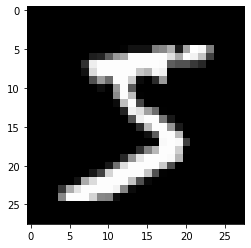

In [26]:
with tf.device('CPU:0'):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print('Predicted result is: %s, target result is: %s' % (result.numpy(), sample_label))
    plt.imshow(sample, cmap=plt.get_cmap('gray'))

**RNNs with list/dict inputs, or nested inputs**

Nested 结构可以在一个时间步内包含更多信息，例如，一个video frame 在同一时刻既有视频信息又有音频信息，如：
```
[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]
```

下面的例子展示了如何创建可以接收结构化输入的 RNN cell：

In [27]:
class NestedCell(tf.keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)
        
    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]
        
        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer='uniform', name='kernel_1')
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer='uniform',
            name='kernel_2_3')
        
    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum('bij,ijkl->bkl', input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states
    
    def get_config(self):
        return {'unit_1':self.unit_1,  'unit_2':unit_2, 'unit_3':self.unit_3}

In [28]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 100
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = tf.keras.layers.RNN(cell)

input_1 = tf.keras.Input((None, i1))
input_2 = tf.keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = tf.keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [29]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

Train on 6400 samples
6400/6400 [==============================] - 33s 5ms/sample - loss: 0.3769 - rnn_1_loss: 0.1181 - rnn_1_1_loss: 0.2588 - rnn_1_accuracy: 0.1009 - rnn_1_1_accuracy: 0.0337
